In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set'

In [4]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

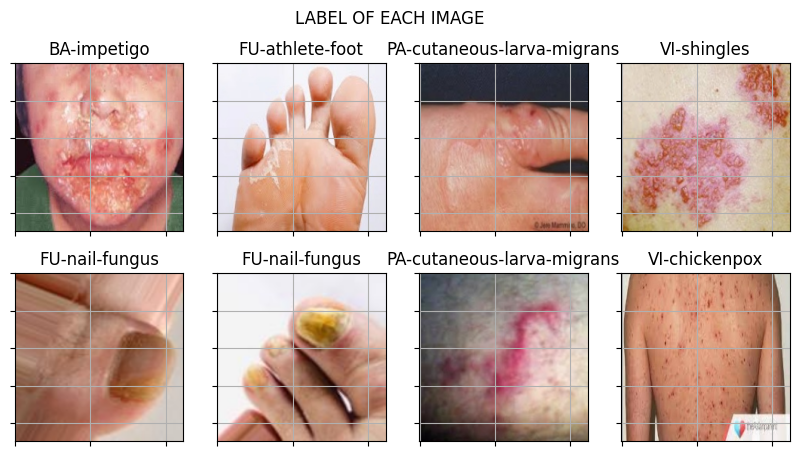

In [5]:
fig,axes=plt.subplots(2,4,figsize=(10,5))
plt.suptitle('LABEL OF EACH IMAGE')
for (img,label),ax in zip (random.sample(train_data,8),axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()    

In [6]:
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

94765736/94765736 [==============================] - 4s 0us/step


In [7]:
base_model.trainable=False

In [8]:
num_classes=8
x=GlobalAveragePooling2D()(base_model.output)
x=Dense(512,activation='relu')(x)
predictions=Dense(num_classes,activation='softmax')(x)

In [9]:
model=Model(inputs=base_model.input,outputs=predictions)
model.compile(optimizer='adam',loss='categorical_crossentropy')
metrics=['accuracy']

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [11]:
X_train,y_train=zip(*train_data)
X_val,y_val=zip(*val_data)

In [12]:
X_train=preprocess_input(np.array(X_train))
X_val=preprocess_input(np.array(X_val))
le=LabelEncoder()
y_train_encoded=le.fit_transform(y_train)
y_val_encoded=le.fit_transform(y_val)
y_train_one_hot=to_categorical(y_train_encoded,num_classes)
y_val_one_hot=to_categorical(y_val_encoded,num_classes)

In [13]:
EPOCHS=12
BATCH_SIZE=32
history=model.fit(X_train,y_train_one_hot,validation_data=(X_val,y_val_one_hot),
                 epochs=EPOCHS,batch_size=BATCH_SIZE)
model.save('/kaggle/working/my_model.h5')

Epoch 1/12
24/24 [==============================] - 13s 168ms/step - loss: 0.8857 - val_loss: 0.2987
Epoch 2/12
24/24 [==============================] - 2s 72ms/step - loss: 0.0991 - val_loss: 0.1410
Epoch 3/12
24/24 [==============================] - 2s 72ms/step - loss: 0.0534 - val_loss: 0.1092
Epoch 4/12
24/24 [==============================] - 2s 72ms/step - loss: 0.0191 - val_loss: 0.0742
Epoch 5/12
24/24 [==============================] - 2s 73ms/step - loss: 0.0061 - val_loss: 0.0644
Epoch 6/12
24/24 [==============================] - 2s 73ms/step - loss: 0.0031 - val_loss: 0.0660
Epoch 7/12
24/24 [==============================] - 2s 72ms/step - loss: 0.0017 - val_loss: 0.0593
Epoch 8/12
24/24 [==============================] - 2s 73ms/step - loss: 0.0013 - val_loss: 0.0599
Epoch 9/12
24/24 [==============================] - 2s 73ms/step - loss: 0.0011 - val_loss: 0.0627
Epoch 10/12
24/24 [==============================] - 2s 72ms/step - loss: 0.0010 - val_loss: 0.0621
Epoch 1

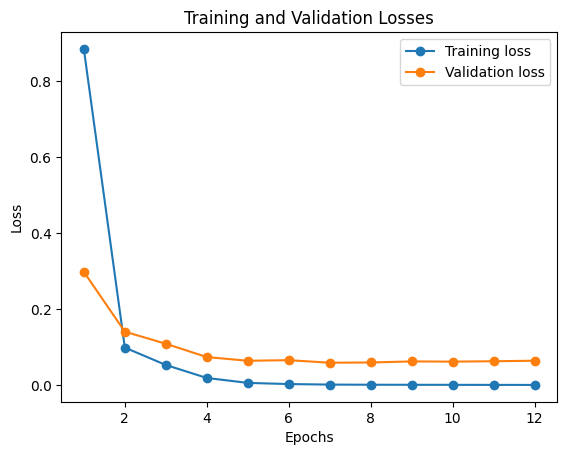

In [14]:
# Get the training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [15]:
from tensorflow.keras.models import load_model

In [16]:
test_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set'

In [17]:
model = load_model('/kaggle/working/my_model.h5') 

In [18]:
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])

1/1 [==============================] - 0s 23ms/step


In [19]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)

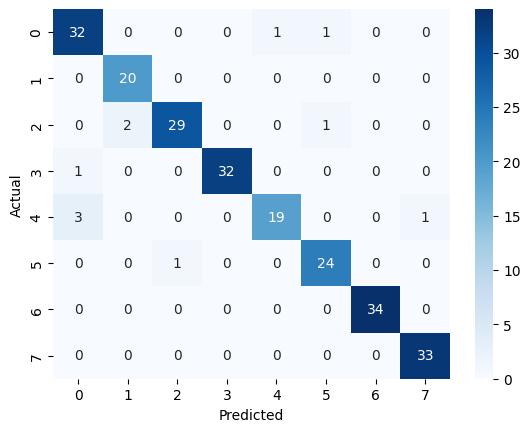

In [20]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()